# **Machine Learning for detector design, modelling the TileCal degradation history as a use case**

The central hadronic calorimeter of the ATLAS/LHC experiment, TileCal, plays a major role in the measurement of jets, missing energy and in the trigger decision. As such, the good operation and performance of this system have been crucial to the wealth of scientific output of ATLAS so far.

Learn more about TileCal [here](https://iopscience.iop.org/article/10.1088/1748-0221/8/01/P01005/pdf).




<font color='green'>It uses iron plates as absorber and plastic scintillating tiles
as the active material. Scintillation light produced in the
tiles is transmitted by wavelength shifting fibres to
photomultiplier tubes (PMTs). The resulting electronic
signals from the approximately 10000 PMTs</font>

<img src=https://lip.pt/~rute/TileAgeing/ATLAS.jpeg width="650">


[APONTAMENTO](https://indico.fnal.gov/event/46746/contributions/210068/attachments/141168/177706/cpadTalk_20210318_final2.pdf)


## TileCal working principle

TileCal employs plastic scintillators to measure the energy of particles: scintillating light is emitted by the crossing of ionising particles and the light is collected by wavelength-shifting optical fibres from the tile's edges and guided to photomultipliers for the signal readout.

<img src=https://lip.pt/~rute/TileAgeing/tileModule.jpeg width="450">

## TileCal geometry

- 64 wedged modules ($\Delta\phi$ = 0.1)
- Fibres from each tile are grouped together to fine the unit readout cell:
  - A, B(C) and D layers
  - Pseudorapidity $\eta$ segmentation of 0.1/0.2 depending on the cell type

<img src=https://lip.pt/~rute/TileAgeing/calorimeters.jpeg width="650">

  <img src=https://lip.pt/~rute/TileAgeing/tileSegmentation.png width="650">






## TileCal degradation

Plastic scintillators have the advantage of being low cost and easy to shape. The drawback of this option is radiation damage.

The plot shows the relative light yield I/I0 of scintillators and wavelength-shifting fibres for the A13 cell as a function of the deposited dose during the LHC Run 2.

<img src=https://twiki.cern.ch/twiki/pub/AtlasPublic/ApprovedPlotsTileCalibrationCombined/LightLoss_doseGEANT4run2_scintOnly_A13_2015201620172018_log_Cs.pdf width="450">

This aspect can be especially critical for the upcoming High Luminosity LHC phase which will bring more dose exposure to the detector, but is also a unique opportunity to probe the detector to the limits and gather knowledge for the design of future experiments.

## Modeling the Tilecal degradation

The objective of this project is to model the degradation of the TileCal scintillators and optical fibres with Machine Learning regression to investigate the dependencies on the specific detector design parameters (scintillators/fibres sizes and others) and run conditions (integrated dose and dose rate). 
The aim is, for instance, to determine which elements of the detector are the weakest links in terms of damage: the optical fibres collecting light from the scintillators or the scintillator tiles themselves. Such results would add to a current fundamental discussion about state-of-the-art calorimetry.

<img src=https://lip.pt/~rute/TileAgeing/tileData.png width="850">

Basically, we want the Machine Learning model to learn this function to let us inspect what are the explicit dependecies... (ask me more about it :-))

<img src=https://lip.pt/~rute/TileAgeing/tileAgeingDNN.png width="850">



# **Let's start!**

## Import the relevant python libraries

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sn

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, BatchNormalization
from keras import backend as K
from sklearn.preprocessing import StandardScaler
from numpy import random
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import files

%matplotlib inline 



## Load the data

In [ ]:
data = pd.read_csv("https://www.lip.pt/~rute/TileAgeing/LightLoss_2015201620172018.csv",delimiter=" ")

data.columns

Index(['cell', 'module', 'channel', 'nlayers', 'ntiles', 'nshortfibres',
       'nlongfibres', 'lminfibre', 'lmaxfibre', 'tileheight', 'lmintile',
       'lmaxtile', 'doserate', 'doserateRMS', 'date', 'intluminosity', 'dose',
       'doseRMS', 'lightyield'],
      dtype='object')

## Data explained

Each row corresponds to a measurement of the light yield for a given cell and has the following variables:

- '**cell**': cell type, eg. A1
- '**module**': module type (LB-Long Barrel / EB-Extended Barrel) + side (A/C) and number (1-64), eg. LBA35, EBC48, LBC15, LBA26
- '**channel**': readout channel numbering convention, maps each cell type into two channels (cells have double readout), more about it [here](http://zenis.dnp.fmph.uniba.sk/tile.html)
- '**nlayers**': number of scintillator layers in the cell along the radial direction, eg. 3 layers for the A cells
- '**ntiles**': total number of tile scintillators in the cell
- '**nshortfibres**': number of short optical fibres in the cell (fibres reading tiles closer to the PMTs are shorter)
- '**nshortfibres**': number of long optical fibres in the cell (fibres reading tiles futher away from the PMTs are longer)
- '**lminfibre/lmaxfibre**': short/long fibre size
- '**tileheight**': height of the tiles (along the radial direction)
- '**lmintile**': shortest tile width (tiles are trapezoidal)
- '**lmaxtile**': longest tile width (tiles are trapezoidal)
- '**doserate**': average dose rate within the cell volume
- '**doserateRMS**': RMS of the dose rate distribution within the cell volume
- '**date**': date of the measurement
- '**intluminosity**': measure of the number of LHC collision events by the time of the measurement (the cell dose will be proportional to this value - with more collisions there is more dose exposure)
- '**dose**': average dose within the cell volume by the time of the measurement
- '**dose**': RMS of the dose within the cell volume by the time of the measurement
- '**lightyield**': measured light yield


Note: Dose-related values are simulated.




## Variables for training
We drop features without physical meaning such as cell naming conventions...

In [ ]:
input_features = ['nlayers', 'ntiles', 'nshortfibres',
        'nlongfibres', 'lminfibre', 'lmaxfibre', 
        'tileheight', 'lmintile', 'lmaxtile', 
        'doserate', 'doserateRMS', 'date', 
        'intluminosity', 'dose', 'doseRMS']

## Divide the data into a training and a test set

We want to verify if the Neural Network is learning/modelling well the degradation of the cells, so we will use:

- **odd cells** (A1, A3,...) for training
- **even cells** (A2, A4,...) for testing

Is the Neural Network able to correctly predict the degradation of eg. the A2 cell without having access to the cells conditions during training? If yes, then it is learning the physics behind the data!



In [ ]:
train_cells=[]
test_cells =[]

for cell in data['cell'].unique():

    if cell in ['D5','D6']: continue
    
    even = (int(cell[-1])+1)%3==0
    
    if even: test_cells.append(cell)
    else: train_cells.append(cell)

print('train cells ', train_cells)
print('test cells ', test_cells)

train cells  ['A1', 'A3', 'A4', 'A6', 'A7', 'A9', 'A10', 'A13', 'A14', 'A16', 'BC1', 'BC3', 'BC4', 'BC6', 'BC7', 'B9', 'C10', 'B11', 'B13', 'B14', 'D0', 'D1', 'D3', 'D4']
test cells  ['A2', 'A5', 'A8', 'A12', 'A15', 'BC2', 'BC5', 'BC8', 'B12', 'B15', 'D2']


In [ ]:
# Some clean-up of residual defectuous data that we know about (malfunctioning channels etc...)
data_clean = data.query('lightyield < 1.01 & lightyield > 0.7')

print(f'Clean data samples {len(data_clean)}/{len(data)}')

train_data = data_clean.query('cell in @train_cells')
test_data  = data_clean.query('cell in @test_cells')
print(f'Training data samples {len(train_data)}')
print(f'Test     data samples {len(test_data)}')

Clean data samples 126487/139332
Training data samples 84976
Test     data samples 40032


In [ ]:
# Normalize/Standardize data (mean = 0  and std = 1)
from sklearn.preprocessing import StandardScaler
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

scaler=StandardScaler()

scaler.fit(train_data[input_features].values)
train_data_std_f=scaler.transform(train_data[input_features].values)

test_data_std_f=scaler.transform(test_data[input_features].values)

# We tranform them into a dataframe and the column's label
train_data_std_f=pd.DataFrame(train_data_std_f).set_axis(input_features, axis=1, inplace=False)
test_data_std_f=pd.DataFrame(test_data_std_f).set_axis(input_features, axis=1, inplace=False)

train_data_std_f

,nlayers,ntiles,nshortfibres,nlongfibres,lminfibre,lmaxfibre,tileheight,lmintile,lmaxtile,doserate,doserateRMS,date,intluminosity,dose,doseRMS
0,-0.483002,-1.150495,-0.850563,-0.845926,0.629912,0.710873,-0.869784,-0.782130,-1.027380,0.614749,0.561441,-1.036100,-0.469381,-0.223872,-0.234702
1,-0.483002,-1.150495,-0.850563,-0.845926,0.629912,0.710873,-0.869784,-0.782130,-1.027380,0.614749,0.561441,-0.378896,-0.466264,-0.218972,-0.229937
2,-0.483002,-1.150495,-0.850563,-0.845926,0.629912,0.710873,-0.869784,-0.782130,-1.027380,0.614749,0.561441,-0.322450,-0.466264,-0.218972,-0.229937
3,-0.483002,-1.150495,-0.850563,-0.845926,0.629912,0.710873,-0.869784,-0.782130,-1.027380,0.614749,0.561441,-0.152605,-0.440188,-0.177990,-0.190085
4,-0.483002,-1.150495,-0.850563,-0.845926,0.629912,0.710873,-0.869784,-0.782130,-1.027380,0.614749,0.561441,-1.036100,-0.469381,-0.223872,-0.234702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84971,-1.207807,-0.866912,-0.497668,-0.571585,-2.449291,-2.445111,2.089053,2.180884,1.607109,-0.537426,-0.479202,2.608253,2.634976,1.015760,1.237264
84972,-1.207807,-0.866912,-0.497668,-0.571585,-2.449291,-2.445111,2.089053,2.180884,1.607109,-0.537426,-0.479202,2.608253,2.634976,1.015760,1.237264
84973,-1.207807,-0.866912,-0.497668,-0.571585,-2.449291,-2.445111,2.089053,2.180884,1.607109,-0.537426,-0.479202,2.608253,2.634976,1.015760,1.237264
84974,-1.207807,-0.866912,-0.497668,-0.571585,-2.449291,-2.445111,2.089053,2.180884,1.607109,-0.537426,-0.479202,2.608253,2.634976,1.015760,1.237264


## Create the Machine Learning Model

We'll start with a Deep Neural Network for Regression problems

#Hyperparameter optimization

In [ ]:
for j in [20,30,40,50,70]:
  for i in range(3):
    NN_model = Sequential()
    # The Input Layer
    NN_model.add(Dense(j, kernel_initializer='normal',input_dim = train_data_std_f[input_features].shape[1], activation='relu'))
    if i ==1:
      NN_model.add(Dense(j, kernel_initializer='normal',activation='sigmoid'))
    if i ==2:
      NN_model.add(Dense(j, kernel_initializer='normal',activation='sigmoid'))
      NN_model.add(Dense(j, kernel_initializer='normal',activation='sigmoid'))

    # The Output Layer
    NN_model.add(Dense(1, kernel_initializer='normal',activation='sigmoid'))


    # Compile the network

    # Change the learning rate of our model
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    NN_model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_absolute_error'])
    NN_model.summary()
    history=NN_model.fit(train_data_std_f, train_data['lightyield'].values, epochs=20, batch_size=32, validation_split = 0.5, shuffle=True,callbacks=EarlyStopping(patience=3))
    # Prediction
    y_pred = NN_model.predict(test_data_std_f, verbose=1)
    a=y_pred.T[0] # Transpomos o vetor com os valores previstos

    # Real Values
    b=test_data['lightyield'].T.values

    # Ratio between the two
    ratios=-(b-a)
    print(f"\n mean:{ np.mean(ratios):.4f}")
    print(f" RMSE:{ np.std(ratios):.4f}\n")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                320       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1328/1328 [==============================] - 4s 2ms/step - loss: 0.2848 - mean_absolute_error: 0.2848 - val_loss: 0.3462 - val_mean_absolute_error: 0.3462
Epoch 2/20
1328/1328 [==============================] - 5s 4ms/step - loss: 0.0485 - mean_absolute_error: 0.0485 - val_loss: 0.1834 - val_mean_absolute_error: 0.1834
Epoch 3/20
1328/1328 [==============================] - 3s 2ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_los

### Com sigmoid

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-c3ow">Hidden Layers</th>
    <th class="tg-baqh">Depth</th>
    <th class="tg-baqh">Mean</th>
    <th class="tg-baqh">RMSE</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">20</td>
    <td class="tg-baqh">-0.0152</td>
    <td class="tg-baqh">0.0359</td>
  </tr>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">30</td>
    <td class="tg-baqh">-0.0011</td>
    <td class="tg-baqh">0.0089</td>
  </tr>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">50</td>
    <td class="tg-baqh">-0.0011</td>
    <td class="tg-baqh">0.0097</td>
  </tr>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">80</td>
    <td class="tg-baqh">-0.0072</td>
    <td class="tg-baqh">0.0233</td>
  </tr>
  <tr>
    <td class="tg-baqh">2</td>
    <td class="tg-baqh">20</td>
    <td class="tg-baqh">0.0002</td>
    <td class="tg-baqh">0.0080</td>
  </tr>
  <tr>
    <td class="tg-baqh">2</td>
    <td class="tg-baqh">30</td>
    <td class="tg-baqh">-0.0106</td>
    <td class="tg-baqh">0.0264</td>
  </tr>
  <tr>
    <td class="tg-baqh">2</td>
    <td class="tg-baqh">50</td>
    <td class="tg-baqh">0.0001</td>
    <td class="tg-baqh">0.0083</td>
  </tr>
  <tr>
    <td class="tg-baqh">2</td>
    <td class="tg-baqh">80</td>
    <td class="tg-baqh">-0.0014</td>
    <td class="tg-baqh">0.0093</td>
  </tr>
  <tr>
    <td class="tg-baqh">3</td>
    <td class="tg-baqh">20</td>
    <td class="tg-baqh">-0.0269</td>
    <td class="tg-baqh">0.0703</td>
  </tr>
  <tr>
    <td class="tg-baqh">3</td>
    <td class="tg-baqh">30</td>
    <td class="tg-baqh">-0.0001</td>
    <td class="tg-baqh">0.0083</td>
  </tr>
  <tr>
    <td class="tg-baqh">3</td>
    <td class="tg-baqh">50</td>
    <td class="tg-baqh">0.0007</td>
    <td class="tg-baqh">0.0075</td>
  </tr>
  <tr>
    <td class="tg-baqh">3</td>
    <td class="tg-baqh">80</td>
    <td class="tg-baqh">-0.0093</td>
    <td class="tg-baqh">0.0218</td>
  </tr>
</tbody>
</table>

### Com relu
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-c3ow">Hidden Layers</th>
    <th class="tg-baqh">Depth</th>
    <th class="tg-baqh">Mean</th>
    <th class="tg-baqh">RMSE</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">20</td>
    <td class="tg-baqh">-0.0082</td>
    <td class="tg-baqh">0.0316</td>
  </tr>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">30</td>
    <td class="tg-baqh">-0.0187</td>
    <td class="tg-baqh">0.0567</td>
  </tr>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">50</td>
    <td class="tg-baqh">-0.0038</td>
    <td class="tg-baqh">0.0188</td>
  </tr>
  <tr>
    <td class="tg-baqh">1</td>
    <td class="tg-baqh">80</td>
    <td class="tg-baqh">-0.0092</td>
    <td class="tg-baqh">0.0280</td>
  </tr>
  <tr>
    <td class="tg-baqh">2</td>
    <td class="tg-baqh">20</td>
    <td class="tg-baqh">-0.0064</td>
    <td class="tg-baqh">0.0260</td>
  </tr>
  <tr>
    <td class="tg-baqh">2</td>
    <td class="tg-baqh">30</td>
    <td class="tg-baqh">-0.0121</td>
    <td class="tg-baqh">0.0314</td>
  </tr>
  <tr>
    <td class="tg-baqh">2</td>
    <td class="tg-baqh">50</td>
    <td class="tg-baqh">-0.0048</td>
    <td class="tg-baqh">0.0220</td>
  </tr>
  <tr>
    <td class="tg-baqh">2</td>
    <td class="tg-baqh">80</td>
    <td class="tg-baqh">-0.0035</td>
    <td class="tg-baqh">0.0292</td>
  </tr>
  <tr>
    <td class="tg-baqh">3</td>
    <td class="tg-baqh">20</td>
    <td class="tg-baqh">-0.0001</td>
    <td class="tg-baqh">0.0224</td>
  </tr>
  <tr>
    <td class="tg-baqh">3</td>
    <td class="tg-baqh">30</td>
    <td class="tg-baqh">-0.0091</td>
    <td class="tg-baqh">0.0292</td>
  </tr>
  <tr>
    <td class="tg-baqh">3</td>
    <td class="tg-baqh">50</td>
    <td class="tg-baqh">-0.0074</td>
    <td class="tg-baqh">0.0252</td>
  </tr>
  <tr>
    <td class="tg-baqh">3</td>
    <td class="tg-baqh">80</td>
    <td class="tg-baqh">-0.0037</td>
    <td class="tg-baqh">0.0207</td>
  </tr>
</tbody>
</table>

# DNN creation

The number of neurons in each layer is not really sensible. Usually you put a bit more or as much neurones on the first layer than inputs, and you decrease slowly until the last layer.

In [ ]:
NN_model = Sequential()

# The Input Layer
NN_model.add(Dense(50, kernel_initializer='normal',input_dim = train_data_std_f[input_features].shape[1], activation='relu'))

# The Hidden Layers
NN_model.add(Dense(50, kernel_initializer='normal',activation='sigmoid'))

NN_model.add(Dense(50, kernel_initializer='normal',activation='sigmoid'))


# The Output Layer
NN_model.add(Dense(1, kernel_initializer='normal',activation='sigmoid'))


# Compile the network

# Change the learning rate of our model
opt = keras.optimizers.Adam(learning_rate=0.0001)
NN_model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_absolute_error'])
NN_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                800       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5,951
Trainable params: 5,951
Non-trainable params: 0
_________________________________________________________________


### Fit the model to the data (Training phase)

Epoch 1/20
1328/1328 [==============================] - 4s 3ms/step - loss: 0.1299 - mean_absolute_error: 0.1299 - val_loss: 0.0275 - val_mean_absolute_error: 0.0275
Epoch 2/20
1328/1328 [==============================] - 3s 3ms/step - loss: 0.0131 - mean_absolute_error: 0.0131 - val_loss: 0.0090 - val_mean_absolute_error: 0.0090
Epoch 3/20
1328/1328 [==============================] - 3s 3ms/step - loss: 0.0087 - mean_absolute_error: 0.0087 - val_loss: 0.0063 - val_mean_absolute_error: 0.0063
Epoch 4/20
1328/1328 [==============================] - 3s 3ms/step - loss: 0.0081 - mean_absolute_error: 0.0081 - val_loss: 0.0058 - val_mean_absolute_error: 0.0058
Epoch 5/20
1328/1328 [==============================] - 3s 3ms/step - loss: 0.0060 - mean_absolute_error: 0.0060 - val_loss: 0.0057 - val_mean_absolute_error: 0.0057
Epoch 6/20
1328/1328 [==============================] - 3s 3ms/step - loss: 0.0052 - mean_absolute_error: 0.0052 - val_loss: 0.0055 - val_mean_absolute_error: 0.0055
Epoc

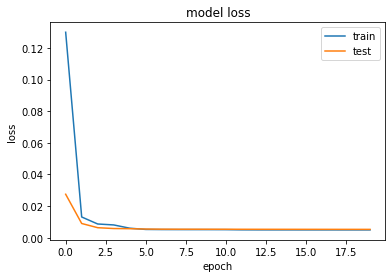

In [ ]:
history=NN_model.fit(train_data_std_f, train_data['lightyield'].values, epochs=20, batch_size=32, validation_split = 0.5, shuffle=True,callbacks=EarlyStopping(patience=3))


print(history.history.keys())

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
#plt.yscale("log")
plt.show()


### Use the model to predict the light yield for the test data (Test phase)

### Evaluate the model: compare the model prediction to the real measurement

1251/1251 [==============================] - 1s 995us/step

 mean:0.0006
 RMSE:0.0075



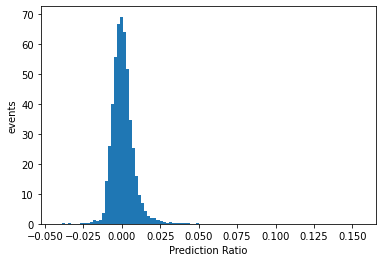

In [ ]:
# Histogram of ratio between real light yield values and predicted ones

# Prediction
y_pred = NN_model.predict(test_data_std_f, verbose=1)
a=y_pred.T[0] # Transpomos o vetor com os valores previstos

# Real Values
b=test_data['lightyield'].T.values

# Ratio between the two
ratios=-(b-a)

# Ratio Histogram
fig, ax = plt.subplots()
plt.hist(ratios, bins = 100, density = True)
xmin, xmax = ax.get_xlim()

plt.ylabel('events')
plt.xlabel('Prediction Ratio')

#plt.yscale("log")

print(f"\n mean:{ np.mean(ratios):.4f}")
print(f" RMSE:{ np.std(ratios):.4f}\n")




## **Correlation matrix**
In this step we develop a correlation matrix between the values.

A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables

-1 indicates a perfectly negative linear correlation between two variables. 

0 indicates no linear correlation between two variables.

1 indicates a perfectly positive linear correlation between two variables.



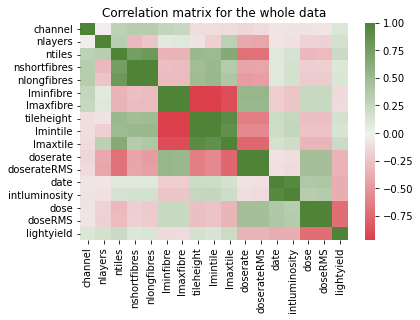

In [ ]:
# Correlation values of the whole measured data

%matplotlib inline 

df = pd.DataFrame(data_clean)
cmap = sn.diverging_palette(10, 120, as_cmap=True)
covMatrix = pd.DataFrame.corr(df)
sn.heatmap(covMatrix, annot=False, fmt='g',cmap=cmap,center=0.00)
plt.title('Correlation matrix for the whole data')
plt.show()


# Set of pseudo-data where varying only the fibre length variables

In this section we create 3 new dataset, where we vary only one collumn. The other collumns are set to it's mean value.

*   lmaxfibre
*   lminfibre
*   dose

**Caution**
### We take in account that we should not change much of it's initial value compared to the initial dataset. This is due to the fact that the NN model is good at interpolating data and not at extrapolating scenarios




In [ ]:
# New dataset creation with fxed valued collumns with a random one
# The goal is to study the light yield as a function of fiber length

from numpy import random

# We get the value from the cell A1
A1CellData=data.loc[data['cell'] == 'A1']
A1CellData=A1CellData.query('lightyield < 0.965') # & lightyield > 0.70' )


# We copy A1's data to a new data set
datablank=A1CellData.copy()

# We use the mean of the columns has their immutable value
for i in input_features:
  mean = A1CellData[i].mean()
  datablank[i]=A1CellData[i].apply(lambda x: mean)



# Dataset with equal columns but random max fiber length value (200-214)

maxfiber_dataset=datablank.copy()
maxfiber_dataset["lmaxfibre"]=maxfiber_dataset["lmaxfibre"].apply(lambda x: random.rand()*15+200)

# Dataset with equal columns but random max fiber length value (120-240)
minfiber_dataset=datablank.copy()
minfiber_dataset["lminfibre"]=minfiber_dataset["lminfibre"].apply(lambda x: random.rand()*10+190)

# Dataset with equal columns but random ntiles
ntiles_dataset=datablank.copy()
ntiles_dataset["ntiles"]=ntiles_dataset["ntiles"].apply(lambda x: random.rand()*1+42.5)


# Since the model was trained with normalized data we need to normalize these
# datasets too
minfiber_dataset=scaler.transform(minfiber_dataset[input_features].values)
maxfiber_dataset=scaler.transform(maxfiber_dataset[input_features].values)
ntiles_dataset=scaler.transform(ntiles_dataset[input_features].values)

# We tranform them into a data frame and the column's label
minfiber_dataset=pd.DataFrame(minfiber_dataset).set_axis(input_features, axis=1, inplace=False)
maxfiber_dataset=pd.DataFrame(maxfiber_dataset).set_axis(input_features, axis=1, inplace=False)
ntiles_dataset=pd.DataFrame(ntiles_dataset).set_axis(input_features, axis=1, inplace=False)



In [ ]:
# Model's predicted values for Light yield of our new datasets

y_pred_min = NN_model.predict(minfiber_dataset[input_features].values)

y_pred_max = NN_model.predict(maxfiber_dataset[input_features].values)

y_pred_ntiles = NN_model.predict(ntiles_dataset[input_features].values)

y_pred_doserate = NN_model.predict(ntiles_dataset[input_features].values)


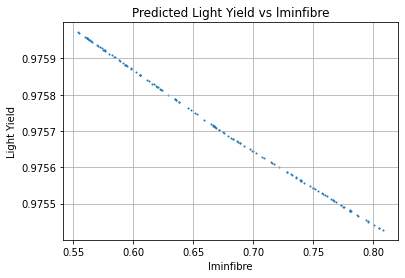

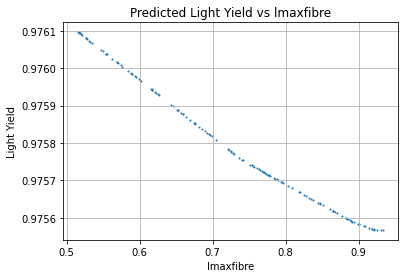

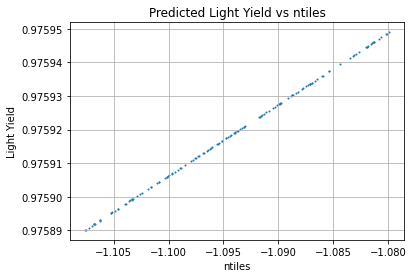

In [ ]:
# Lights yield vs l min
plt.title('Predicted Light Yield vs lminfibre')

plt.scatter(minfiber_dataset["lminfibre"],y_pred_min,s=1)
#plt.title('Predicted Light Yield vs lminfibre')
plt.xlabel("lminfibre")
plt.ylabel('Light Yield')
plt.grid()
plt.show()

# Lights yield vs l max

plt.scatter(maxfiber_dataset["lmaxfibre"],y_pred_max,s=1)
plt.title('Predicted Light Yield vs lmaxfibre')
plt.xlabel("lmaxfibre")
plt.ylabel('Light Yield')
plt.grid()
plt.show()


# Lights yield vs n_tiles

plt.scatter(ntiles_dataset["ntiles"],y_pred_ntiles,s=1)
plt.title('Predicted Light Yield vs ntiles')
plt.xlabel("ntiles")
plt.ylabel('Light Yield')
plt.grid()
plt.show()




#desnormalizar eixos xx do gráfico?

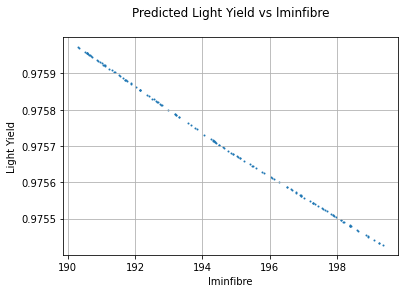

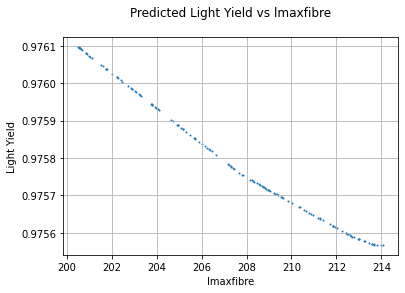

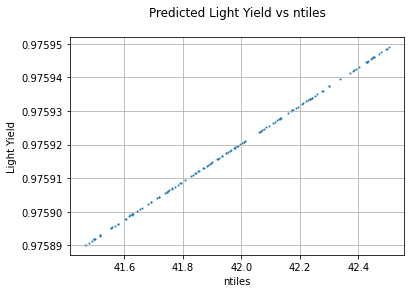

In [ ]:


x=minfiber_dataset["lminfibre"]*np.std(data_clean['lminfibre'])+np.mean(data_clean['lminfibre'])
plt.scatter(x,y_pred_min,s=1)
plt.title('Predicted Light Yield vs lminfibre\n')
plt.xlabel("lminfibre")
plt.ylabel('Light Yield')
plt.grid()
plt.show()


x=maxfiber_dataset["lmaxfibre"]*np.std(data_clean['lmaxfibre'])+np.mean(data_clean['lmaxfibre'])
plt.scatter(x,y_pred_max,s=1)
plt.title('Predicted Light Yield vs lmaxfibre\n')
plt.xlabel("lmaxfibre")
plt.ylabel('Light Yield')
plt.grid()
plt.show()



x=ntiles_dataset["ntiles"]*np.std(data_clean['ntiles'])+np.mean(data_clean['ntiles'])
plt.scatter(x,y_pred_ntiles,s=1)
plt.title('Predicted Light Yield vs ntiles\n')
plt.xlabel("ntiles")
plt.ylabel('Light Yield')
plt.grid()
plt.show()


#Auxiliar
verificar em que medidas se encontram os parâmetros de uma celula

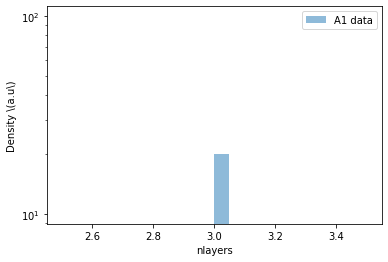

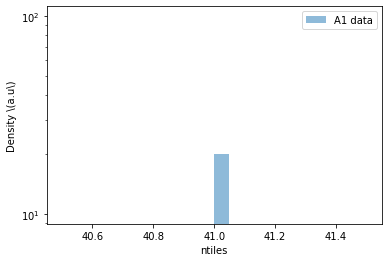

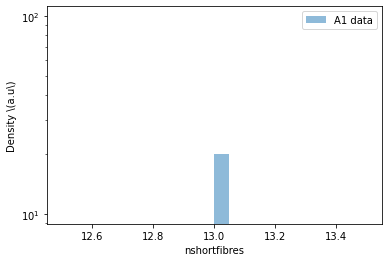

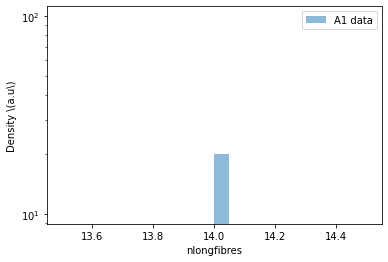

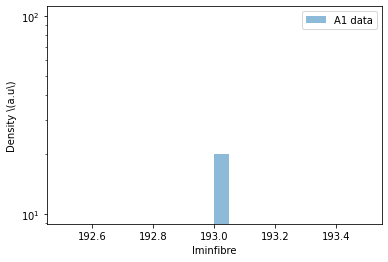

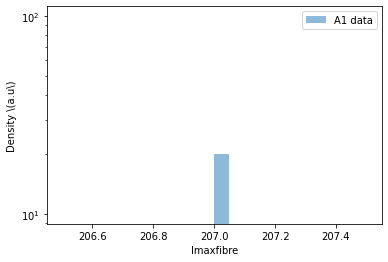

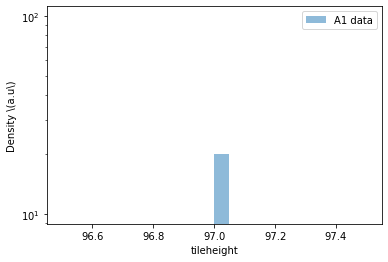

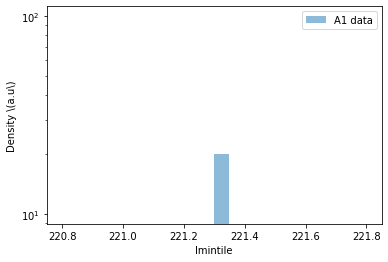

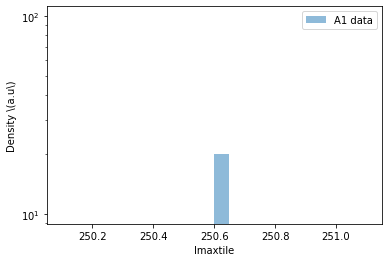

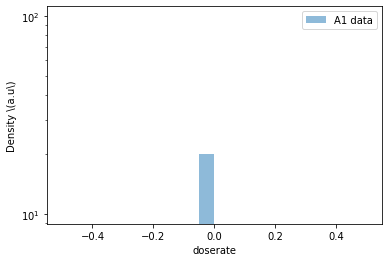

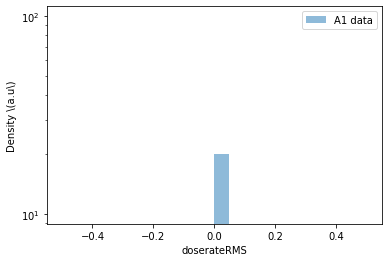

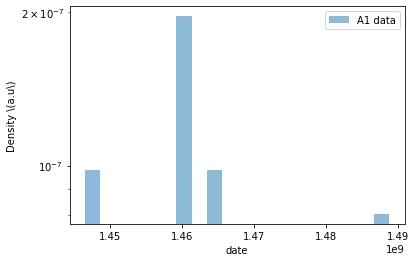

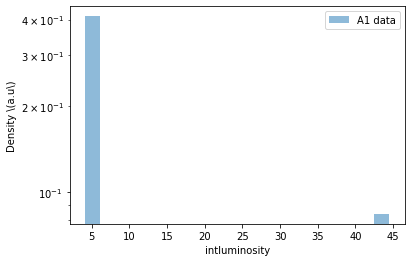

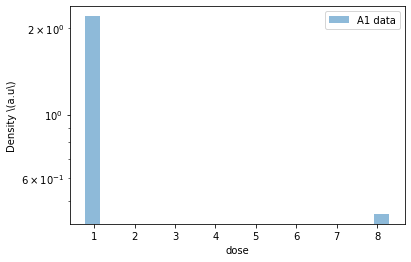

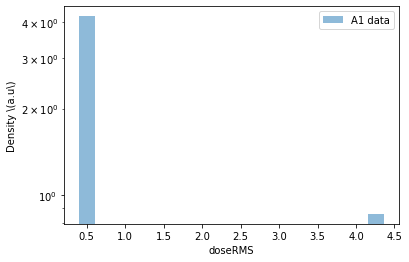

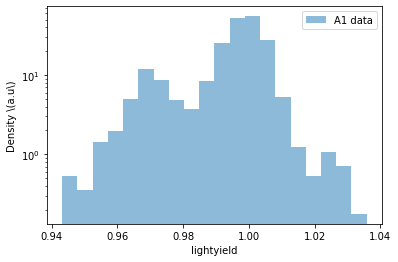

In [ ]:

A1CellData=data.loc[data['cell'] == 'A1']
#A1CellData=A1CellData.query('lightyield < 0.97') # & lightyield > 0.70' )

for feat in input_features+['lightyield']:
    plt.hist(A1CellData[feat].values, 20, density=True, alpha=0.5, label='A1 data')
    
    #vamos fazer um histograma para todos os parâmetros de input + o lightyield que é a saída que procuramos
    
    plt.xlabel(feat)
    plt.ylabel('Density \(a.u\)')
    plt.legend()
    plt.yscale("log")
    plt.show()
